/home/josalferr/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Propagation finished in 1.916 s
Saved z-slices: [0.    0.005 0.025 0.05 ]


/home/josalferr/GNLSE_code (Copy)/gnlse_visualizations.py:122: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(data_sel)
/home/josalferr/GNLSE_code (Copy)/gnlse_visualizations.py:123: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(data_sel)


Saved animation: /home/josalferr/GNLSE_code (Copy)/xy_t_output_window.gif


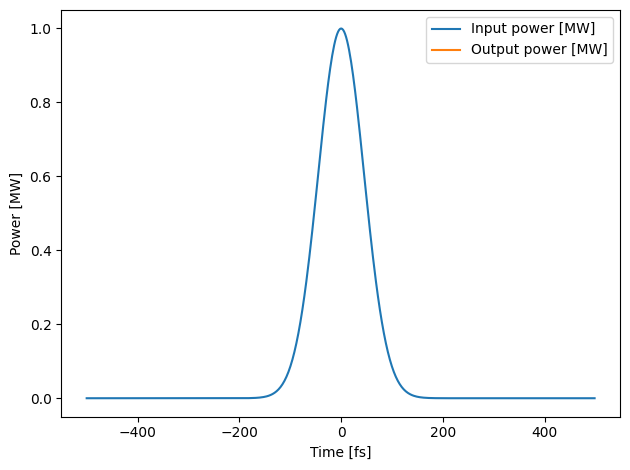

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from gnlse_solver import *
from gnlse_visualizations import *
from gnlse_source import *
from gnlse_medium import *

# -----------------------------
# 1) Define grid and parameters
# -----------------------------
Lx, Ly = 200e-6, 200e-6      # [m] transverse window
Lt     = 1.0e-12             # [s] total time window
Lz     = 0.05                # [m] fiber length (5 cm)

Nx, Ny = 128, 128
Nt     = 512

dx, dy = Lx/Nx, Ly/Ny
dt     = Lt/Nt

lambda0 = 1030e-9            # [m]
n2      = 2.6e-20            # [m^2/W] (silica)
beta0   = 2*np.pi*(1.45/lambda0)           # ~neff*k0 (rough)
beta1   = 1.0/ (3e8/1.468)                 # ~ng/c [s/m]  (example)
beta2   = 23e-27                            # [s^2/m] ~ +23 fs^2/mm

deltaZ     = 200e-6           # [m] linear step
deltaZ_NL  = 200e-6           # [m] NL step (same here)
steps_total = int(Lz/deltaZ)

# Save at a few positions (including output)
save_at = np.array([0.0, Lz/10, Lz/2, Lz])  # [m]

# Raman and options
fr, sw = 0.18, 1              # Raman fraction and self-steepening on/off
t1, t2 = 12.2e-15, 32e-15     # Raman parameters
gain_coeff, gain_fwhm = 0.0, 0.0
saturation_intensity = 1e12   # [J/m^2] (dummy if no gain)

# -----------------------------
# 2) Build material index cube n(x,y,ω)
#    For a material-only example, make it uniform in x,y and dispersive in ω.
# -----------------------------
# Example: flat n(ω) ≈ constant (you can plug a Sellmeier here)
n0 = 1.45
n_xyomega = np.full((Nx, Ny, Nt), n0, dtype=np.float32)

# -----------------------------
# 3) Initial field A0(x,y,t)
#    Gaussian beam × Gaussian pulse; scale spatial part to desired peak power.
# -----------------------------
x = (np.arange(Nx) - Nx/2) * dx
y = (np.arange(Ny) - Ny/2) * dy
t = (np.arange(Nt) - Nt/2) * dt

w0   = 40e-6                                     # [m] beam waist
E_xy = np.exp(- (x[:,None]**2 + y[None,:]**2) / w0**2).astype(np.complex64)
# scale spatial field to peak power P0 (so power at pulse peak equals P0)
P0   = 1e6                                       # 1 MW
area = dx*dy
E_xy = E_xy / np.sqrt(np.sum(np.abs(E_xy)**2)*area) * np.sqrt(P0)

# unit-peak Gaussian temporal envelope
tau_fwhm = 150e-15
sigma = tau_fwhm / (2*np.sqrt(2*np.log(2)))
E_t = np.exp(-0.5*(t/sigma)**2).astype(np.complex64)
E_t = E_t / np.max(np.abs(E_t))                  # unit peak

# outer product → A0(x,y,t)
A0 = (E_xy[:,:,None] * E_t[None,None,:]).astype(np.complex64)

# -----------------------------
# 4) Pack args dict
# -----------------------------
args = dict(
    Lx=Lx, Ly=Ly, Lz=Lz, Lt=Lt,
    Nx=Nx, Ny=Ny, Nt=Nt,
    deltaZ=deltaZ, deltaZ_NL=deltaZ_NL,
    lambda0=lambda0,
    n2=n2,
    n_xyomega=n_xyomega,      # (Nx,Ny,Nt)
    beta0=beta0, beta1=beta1, beta2=beta2,
    gain_coeff=gain_coeff, gain_fwhm=gain_fwhm,
    t1=t1, t2=t2,
    saturation_intensity=saturation_intensity,
    pml_thickness=12,         # in grid cells (as used in your code)
    pml_Wmax=5.0,             # absorption strength
    save_at=save_at,
    fr=fr, sw=sw
)

# -----------------------------
# 5) Call the jitted scan wrapper
# -----------------------------
out = GNLSE3D_propagate_scan(args, jnp.asarray(A0))
# out = {'field': (Nx,Ny,Nt,save_n), 'dt': dt, 'dx': dx, 'seconds': elapsed}

print(f"Propagation finished in {out['seconds']:.3f} s")
print("Saved z-slices:", save_at)

# --------------------------------------------
# 6) Animate only the active time window at z=Lz
# --------------------------------------------
from pathlib import Path
gif_path = "xy_t_output_window.gif"
# Choose a narrow window, e.g., ±300 fs around t=0
t_window = (-300e-15, 300e-15)
_ = make_xy_t_animation(out["field"], z_index=-1, t=t,
                        quantity='intensity', norm='global',
                        t_window=t_window, stride=1,
                        filename=gif_path, fps=30, dpi=120)
print("Saved animation:", Path(gif_path).resolve())

# --------------------------------------------
# 7) Plot temporal power: input vs output
# --------------------------------------------
def power_vs_time_from_results(results, z_index=-1, dx=None, dy=None):
    field4d = results["field"]
    Nx, Ny, Nt, Nz = field4d.shape
    if dx is None or dy is None:
        # we stashed dx,dt separately above
        raise ValueError("Pass dx, dy explicitly here (or extend results to store x,y).")
    F = field4d[..., z_index]                  # (Nx,Ny,Nt)
    P_t = np.sum(np.abs(np.asarray(F))**2, axis=(0,1)) * dx * dy
    return np.real_if_close(P_t, tol=1000)

P_out = power_vs_time_from_results(out, z_index=-1, dx=dx, dy=dy)
P_in  = P0 * np.abs(E_t)**2

plt.figure()
plt.plot(t*1e15, P_in/1e6,  label="Input power [MW]")
plt.plot(t*1e15, P_out/1e6, label="Output power [MW]")
plt.xlabel("Time [fs]"); plt.ylabel("Power [MW]")
plt.legend(); plt.tight_layout(); plt.show()
